In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sys
import os
from keras.applications.vgg16 import VGG16
import keras
from numpy import load
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras import backend
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [3]:
traindir = "/content/drive/MyDrive/plant_disease_dataset/Train"
validdir = "/content/drive/MyDrive/plant_disease_dataset/Validation"
testdir = "/content/drive/MyDrive/plant_disease_dataset/Test"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 64
training_set = train_datagen.flow_from_directory(traindir,
                                                 target_size=(224, 224),
                                                 batch_size=batch_size,
                                                 class_mode='binary')

validation_set = validation_datagen.flow_from_directory(validdir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='binary')


Found 1322 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [4]:
train_num = training_set.samples
valid_num = validation_set.samples

In [5]:
base_model=VGG16(include_top=False,input_shape=(224,224,3))
base_model.trainable=False

58889256/58889256 [==============================] - 1s 0us/step


In [6]:
model=keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
#fitting images to CNN
history = model.fit(training_set, epochs=25, batch_size=64, validation_data=validation_set)

Epoch 1/25
21/21 [==============================] - 842s 39s/step - loss: 0.7427 - accuracy: 0.6301 - val_loss: 0.6507 - val_accuracy: 0.7000
Epoch 2/25
21/21 [==============================] - 830s 40s/step - loss: 0.4306 - accuracy: 0.7859 - val_loss: 0.3085 - val_accuracy: 0.8667
Epoch 3/25
21/21 [==============================] - 807s 38s/step - loss: 0.3386 - accuracy: 0.8548 - val_loss: 0.2525 - val_accuracy: 0.9167
Epoch 4/25
21/21 [==============================] - 789s 38s/step - loss: 0.2813 - accuracy: 0.8850 - val_loss: 0.2191 - val_accuracy: 0.9500
Epoch 5/25
21/21 [==============================] - 794s 38s/step - loss: 0.2608 - accuracy: 0.9047 - val_loss: 0.1939 - val_accuracy: 0.9333
Epoch 6/25
21/21 [==============================] - 831s 39s/step - loss: 0.2306 - accuracy: 0.9198 - val_loss: 0.2418 - val_accuracy: 0.8667
Epoch 7/25
21/21 [==============================] - 805s 38s/step - loss: 0.2261 - accuracy: 0.9153 - val_loss: 0.2113 - val_accuracy: 0.9000
Epoch 

In [9]:
filepath="VGG16_model.h5"
model.save(filepath)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Visualizing the Accuracy

In [10]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


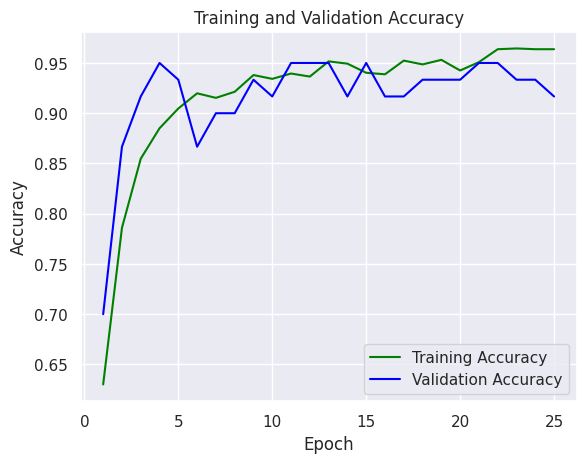

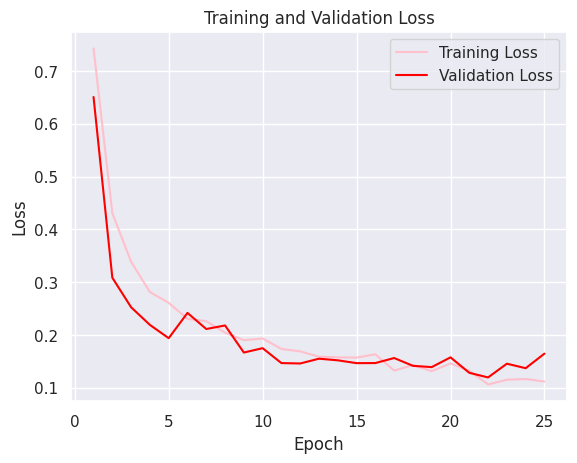

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
# loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
from keras.models import load_model
from keras.preprocessing import image
model = load_model('VGG16_model.h5')

labels = ['Normal', 'Abnormal']

correct_predictions = {'Normal': 0, 'Abnormal': 0}
total_images = {'Normal': 0, 'Abnormal': 0}

for label in labels:
    label_dir = os.path.join(testdir, label)
    images = os.listdir(label_dir)
    total_images[label] = len(images)

    for img_name in images:
        img_path = os.path.join(label_dir, img_name)

        if not os.path.isfile(img_path):
            continue

        try:
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = img_array / 255.0

            prediction = model.predict(img_array)

            if prediction[0][0] > 0.5:
                predicted_label = 'Normal'
            else:
                predicted_label = 'Abnormal'

            if predicted_label == label:
                correct_predictions[label] += 1

            print("Image: {}, Prediction: {}".format(img_path, predicted_label))
        except Exception as e:
            print("Error processing image {}: {}".format(img_path, str(e)))

for label in labels:
    accuracy = correct_predictions[label] / total_images[label] * 100
    print("Accuracy for {}: {:.2f}%".format(label, accuracy))

1/1 [==============================] - 1s 628ms/step
Image: /content/drive/MyDrive/plant_disease_dataset/Test/Normal/healthy16.jpg, Prediction: Normal
1/1 [==============================] - 0s 488ms/step
Image: /content/drive/MyDrive/plant_disease_dataset/Test/Normal/healthy4.jpg, Prediction: Normal
1/1 [==============================] - 0s 464ms/step
Image: /content/drive/MyDrive/plant_disease_dataset/Test/Normal/healthy20.jpg, Prediction: Normal
1/1 [==============================] - 0s 487ms/step
Image: /content/drive/MyDrive/plant_disease_dataset/Test/Normal/healthy38.jpg, Prediction: Normal
1/1 [==============================] - 0s 476ms/step
Image: /content/drive/MyDrive/plant_disease_dataset/Test/Normal/healthy47.jpg, Prediction: Normal
1/1 [==============================] - 0s 474ms/step
Image: /content/drive/MyDrive/plant_disease_dataset/Test/Normal/healthy35.jpg, Prediction: Normal
1/1 [==============================] - 0s 462ms/step
Image: /content/drive/MyDrive/plant_diseas